#Distracted driver detection. 


**An AI challenge by ImaGR to apply with them:**  

*Base model:*  A pretrained VGG16 with batch normalization layers, and a modified classifier with two dense layers. Adam optimizer, 10 epochs, and a batch size of 256. Validation accuracy of 99.64317, and a Kaggle average score of 0.52

*Augmented model: *
Papers: 
- [Attention Augmented Convolutional Networks]()
- [Bag of Tricks for for Image Classification with CNNs]()
- [EfficientNet: Rethinking Model Scaling for CNNs]()




### Connect with Colab

In [0]:
from google.colab import drive
drive.mount("/betogaona7")

In [0]:
%cd ./../betogaona7/My\ Drive/app/Distracted

### Imports 

In [0]:
import os 
import random
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import csv


from torch.utils.data.sampler import SubsetRandomSampler

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from torchvision import models, datasets, transforms, utils
from torchvision.models.vgg import VGG
from torch.utils.data import Dataset

### Helper functions

In [0]:
def unnormalize(img):
  img = (img/2)+0.5 
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

def decode_label(label):
  actions = ["safe driving",
             "texting - right",
             "talking on the phone - right",
             "texting - left",
             "talking on the phone - left",
             "operating the radio",
             "drinking",
             "reaching behing",
             "hair and makeup",
             "talking to passanger"]
  return actions[label]

def transform_matrix_offset_center(matrix, x, y):
  o_x = float(x) / 2 + 0.5
  o_y = float(y) / 2 + 0.5
  offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
  reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
  transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
  return transform_matrix

### Build dataset 

In [6]:
datadir = './data/train'
valid_size= 0.20

train_transforms = transforms.Compose([transforms.RandomAffine(0.2, shear=0.2, scale=(1, 1.2)),
                                       transforms.Resize((64, 64)),
                                       transforms.ColorJitter(0.2),
                                       transforms.
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

valid_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(datadir, transform=train_transforms)
valid_data = datasets.ImageFolder(datadir, transform=valid_transforms)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, num_workers=8, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, sampler=valid_sampler, num_workers=8, batch_size=32)

print(len(train_idx), " samples in training. ")
print(len(valid_idx), " samples in validation.")
print(len(train_idx)+len(valid_idx), " total samples.")
print("Classes: ", trainloader.dataset.classes)

17940  samples in training. 
4484  samples in validation.
22424  total samples.
Classes:  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


### Visualize training samples

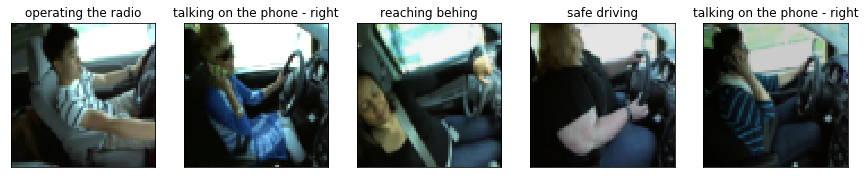

In [7]:
batch = next(iter(trainloader))

imgs = []
actions = []
for i in range(5):
  sample = random.randint(0, 31)
  img =  unnormalize(batch[0][sample])
  action = decode_label(int(batch[1][sample]))
  imgs.append(img)
  actions.append(action)

plot_imgs(imgs, actions, (15,15))

## Model

In [0]:
model = models.vgg16_bn(pretrained=True)
model

### Self-attention mechanism

Employing self-attiention along the entire architecture. 
The use of multi-head attentipn allows the model to attend jointly to both spatial and feature subspaces. 
Enhance the represantional power of self-attention to two dimensional inputs allowing us to model translation equivariance in a principal way.
Produce additional feature maps, rather than recalibrating convolutional features via addition or gating. This allows us tp flexibly adjust the fraction of attention channels and consder  sprectrum of achitectures.



In [0]:
class attentiveConv(nn.Module):
  """
     Perfoms multihead attention. 
     Args: 
      in_channels : (Tensor) Image with dimensions [batch, channels, height, width].
      out_channls : (int) Number of output filters. 
      k_size: (int) Kernel size.
      dk: (int) Depth of queries and keys in multihead attention. 
      dv: (int) Depth of values.
      nh: (int) Number of heads.
      relative: (bool) True for relative positional encodings.
     Return: 
      (tensor) Attention augmented convolution.
  """
  def __init__(self, in_channels, out_channels, k_size, dk, dv, nh, relative=False):
    super(attentiveConv, self).__init__()
    self.f_in = in_channels
    self.f_out = out_channels
    self.k = k_size
    self.dk = dk 
    self.dv = dv
    self.nh = nh
    self.relative = relative
    
    assert self.nh != 0, "nh must be equal or greater than 1"
    assert self.dk % self.nh == 0, "dk must be divisible by nh"
    assert self.dv % self.nh == 0, "dv must be divisible by nh"
    
    self.conv_out = nn.Conv2d(self.f_in, out_channels=self.f_out-self.dv, kernel_size=self.k)
    self.qkv_conv = nn.Conv2d(self.f_in, out_channels= 2*self.dk+self.dv, kernel_size=self.k)
    self.attn_out = nn.Conv2d(self.dv, self.dv, kernel_size=1)

  def forward(self, x):
    conv_out = self.conv_out(x)
    B, _, H, W = conv_out.size()
    
    print(conv_out.size())
    flat_q, flat_k, flat_v, q = self.compute_flat_qkv(x, self.dk, self.dv, self.nh)
    logits = torch.matmul(flat_q.transpose(2, 3), flat_k)
    if self.relative:
      h_rel_logits, w_rel_logits = self.relative_logits(q)
      logits += h_rel_logits
      logits += w_rel_logits 
    weights = nn.functional.softmax(logits, dim=-1)
    attn_out = torch.matmul(weights, flat_v.transpose(2, 3))
    # Reshaped into a tensor (H,W, dv) to match the original spatial dimensions.
    attn_out = torch.reshape(attn_out, (B, self.nh, self.dv // self.nh, H, W))
    attn_out = self.combine_heads_2d(attn_out)
    attn_out = self.attn_out(attn_out)
    
    # Returns an attention augmented convolution
    return torch.cat((conv_out, attn_out), dim=1)
  
  def split_heads_2d(self, x, nh):
    """
      Splits channels into multiple heads.
    """
    B, C, H, W = x.size()
    ret_shape = (B, nh, C // nh, H, W)
    return torch.reshape(x, ret_shape)
  
  def combine_heads_2d(self, x):
    """
      Combine miltiple heads.
    """
    B, nh, dv, H, W = x.size()
    ret_shape = (B, nh*dv, H, W)
    return torch.reshape(x, ret_shape)
  
  def compute_flat_qkv(self, x, dk, dv, nh):
    """
      Computes flattenend queries, keys, and values. 
    """
    qkv = self.qkv_conv(x)
    B, _, H, W = qkv.size()
    q, k, v = torch.split(qkv, [dk, dk, dv], dim=1)
    q = self.split_heads_2d(q, nh)
    k = self.split_heads_2d(k, nh)
    v = self.split_heads_2d(v, nh)
    dkh = dk // nh
    q *= dkh**-0.5
    flat_q = torch.reshape(q, (B, nh, dk // nh, H*W))
    flat_k = torch.reshape(k, (B, nh, dk // nh, H*W))
    flat_v = torch.reshape(v, (B, nh, dv // nh, H*W))
    return flat_q, flat_k, flat_v, q
  
  def rel_to_abs(self, x):
    """
      Convert tensor from relative to absolute indexing.
    """
    B, nh, L, _ = x.size()
    col_pad = torch.zeros((B, nh, L, 1)).to(x)
    x = torch.cat((x, col_pad), dim=3)
    flat_x = torch.reshape(x, (B, nh, L*2*L))
    flat_pad = torch.zeros((B, nh, L-1)).to(x) 
    flat_x_padded = torch.cat((flat_x, flat_pad), dim=2)
    final_x = torch.reshape(flat_x_padded, (B, nh, L+1, 2*L-1))
    return final_x[:, :, :L, L-1:]
  
  def relative_logits_1d(self, q, rel_k, H, W, nh, case):
    """
      Computes relative logits alonge one dimension.
    """
    rel_logits = torch.einsum('bhxyd,md->bhxym', q, rel_k)
    rel_logits = torch.reshape(rel_logits, (-1, nh*H, W, 2*W-1))
    rel_logits = self.rel_to_abs(rel_logits)
    
    rel_logits = torch.reshape(rel_logits, (-1, nh, H, W, W))
    rel_logits = torch.unsqueeze(rel_logits, dim=3)
    rel_logits = rel_logits.repeat((1, 1, 1, H, 1, 1))
    
    if case == "w":
      rel_logits = torch.transpose(rel_logits, 3, 4)
    elif case == "h":
      rel_logits = torch.transpose(rel_logits, 2, 4).transpose(4, 5).transpose(3, 5)
    return torch.reshape(rel_logits, (-1, nh, H*W, H*W))
  
  def relative_logits(self, q):
    """
      Computes relative positions logits. 
    """
    B, nh, dk, H, W = q.size()
    q = torch.transpose(q, 2, 4).transpose(2, 3)
    key_rel_w = nn.Parameter(torch.randn((2*W-1, dk), requires_grad=True)) # Send to device
    rel_logits_w = self.relative_logits_1d(q, key_rel_w, H, W, nh, "w")
    
    key_rel_h = nn.Parameter(torch.randn((2*H-1, dk), requires_grad=True)) # Send to device
    rel_logits_h = self.relative_logits_1d(torch.transpose(q, 2, 3), key_rel_h, W, H, nh, "h")
    return rel_logits_h, rel_logits_w

In [7]:
# ultra computational expesive! 

temp = torch.randn((16, 3, 64, 64))
attentConv1 = attentiveConv(in_channels=3, out_channels=20, k_size=3, dk=40, dv=4, nh=4, relative=False)
conv_out1 = attentConv1(temp)
print(conv_out1.shape)
  
#attentConv2 = attentiveConv(in_channels=3, out_channels=20, k_size=3, dk=40, dv=4, nh=4, relative=True)
#conv_out2 = attentConv2(temp)
#print(conv_out2.shape)

torch.Size([16, 16, 62, 62])
torch.Size([16, 20, 62, 62])


### Modify pretrained model

In [0]:
model.classifier = nn.Sequential(OrderedDict([('0', nn.Linear(25088, 1024)),
                                              ('1', nn.Linear(1024, 10))
                                              ]))
model

## Training

### Check for GPU

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

### Train a single epoch

In [0]:
counter = []
history = []
iteration = 0


for i, batch in enumerate(trainloader):
  images, labels = batch
  images, labels = images.to(device), labels.to(device)
  optimizer.zero_grad()
  
  outputs = model.forward(images)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  print("Minibatch: {} loss: {}".format(i, loss.item()))
  iteration += i
  counter.append(iteration)
  history.append(loss.item())


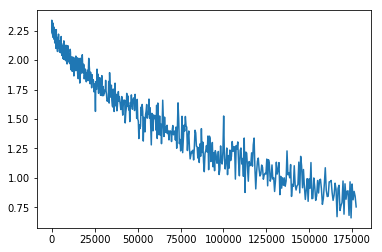

In [0]:
torch.save(model.state_dict(), "./pytorch-model.pth")
plt.plot(counter, history)
plt.show()

### Full training

In [0]:
def validation(model, validloader, criterion):
  correct = 0
  total = 0
  for minibatch, batch in enumerate(validloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [0]:
epochs = 10
print_every = 20

In [0]:
best = 100

for epoch in range(epochs):
  for minibatch, batch in enumerate(trainloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if minibatch % print_every == 0:
      model.eval()
      with torch.no_grad():
        accuracy = validation(model, validloader, criterion)
        training_loss = loss.item()
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Loss: {:.5f}.. ".format(training_loss),
              "Accuracy: {}.. ".format(accuracy))
        if best > training_loss:
          torch.save(model.state_dict(), "./lessloss-accuracy-pytorch6.pth")
          best = training_loss
      model.train()
      
torch.save(model.state_dict(), "./full-trained-pytorch6.pth")

### Evaluate

In [0]:
saved_file = "./lessloss-accuracy-pytorch5.pth"
saved_file2 = "./full-trained-pytorch5.pth"

state_dict = torch.load(saved_file)
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
  acc = validation(model, validloader, criterion)
  print("Validation accuracy: ", acc)

Validation accuracy:  99.64317573595004


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for minibatch, batch in enumerate(validloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    
    for sample in range(32):
      try:
        label = labels[sample]
        class_correct[label] += c[sample].item()
        class_total[label] += 1
      except:
        break
      
for i in range(10):
  print("Accuracy of %5s : %2d %%" % (decode_label(i), 100*class_correct[i]/class_total[i]))
    

Accuracy of safe driving : 100 %
Accuracy of texting - right : 100 %
Accuracy of talking on the phone - right : 100 %
Accuracy of texting - left : 98 %
Accuracy of talking on the phone - left : 100 %
Accuracy of operating the radio : 100 %
Accuracy of drinking : 100 %
Accuracy of reaching behing : 100 %
Accuracy of hair and makeup : 100 %
Accuracy of talking to passanger : 100 %


## Test 

### Move test images to virtual environment file system

In [0]:
!ls ./../../../../content/

In [0]:
!cp data/test.zip  ./../../../../content/

In [0]:
%cd /content
%ls 

In [0]:
!unzip -qq test.zip

In [0]:
%rm test.zip

In [0]:
%cd ./../betogaona7/My\ Drive/app/Distracted

### Get test data

In [0]:
def get_data(src):
  data = []
  total = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if file[-3:] == 'jpg': 
        data.append(os.path.join(path, file))
      total += 1
  return data, total


test_data, total = get_data("./../../../../content/test/")

In [0]:
print("Test sample: ", test_data[0], " Total samples: ", total)

Test sample:  ./../../../../content/test/img_17237.jpg  Total samples:  79726


In [0]:
class stateFarmTestset(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform
    
  def __getitem__(self, index):
    img = self.data[index]
    img_name = img[27:]
    
    img = Image.open(img)
    
    if self.transform is not None:
      img = self.transform(img)
    
    return img, img_name
  
  def __len__(self):
    return len(self.data)

In [0]:
test_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_dataset = stateFarmTestset(test_data, transform = test_transforms)
testloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, num_workers=8, batch_size=256)

### Visualize test sample

(64, 64, 3)


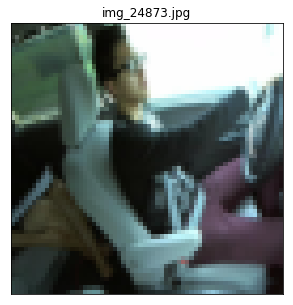

In [0]:
sample = random.randint(0, 64)

batch = next(iter(testloader))

img = unnormalize(batch[0][sample])
img_name = batch[1][sample]

print(img.shape)
plot_imgs([img], [img_name], (5,5))

### Get predictions and create CSV

In [0]:
csvfile = open("predictions.csv", 'w', newline='')
doc = csv.writer(csvfile)
doc.writerow(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

with torch.no_grad():
  for minibatch, batch in enumerate(testloader):
    images, names = batch[0].to(device), batch[1]
    outputs = model(images)
    predictions = outputs.data
    
    for i in range(len(predictions)):
      p = nn.functional.softmax(predictions[i]).cpu().numpy()
      n = names[i]
      doc.writerow([n, p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9]])
      
    if(minibatch%10 == 0):
      print(minibatch, " minibatches tested.")
    
csvfile.close()